# Multitask error vs correct classification


In [2]:
%pip install openneuro-py
%pip install mne-bids


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# you have to install openneuro-py and mne-bids packages
# if using colab, run:
# !pip install openneuro-py
# !pip install mne-bids
# if working locally, install modlules using pip

import os
import os.path as op
import openneuro

from mne.datasets import sample
from mne_bids import (
    BIDSPath,
    read_raw_bids,
    print_dir_tree,
    make_report,
    find_matching_paths,
    get_entity_vals,
)
import mne

import numpy as np

## 1. Download dataset

In [ ]:
dataset = "ds004883"

# number of participants to fetch
n = 30
subjects = [f'sub-{subject:03}' for subject in range(1, n+1)]

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset)
if not op.isdir(bids_root):
    os.makedirs(bids_root)

# this download full dataset, it might took few hours
openneuro.download(dataset=dataset, target_dir=bids_root, include=subjects)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004883 …


📁 Traversing directories for ds004883 : 636 entities [01:19,  8.05 entities/s]

📥 Retrieving up to 635 files (5 concurrent downloads). 
✅ Finished downloading ds004883.
 
🧠 Please enjoy your brains.
 


Re-downloading sub-008_task-ffb_electrodes.tsv: file size mismatch.: 0.00B [00:00, ?B/s]                   

Re-downloading sub-023_task-ffb_coordsystem.json: file size mismatch.: 0.00B [00:00, ?B/s]        
                                                                                          
Re-downloading sub-024_task-ffa_electrodes.tsv: file size mismatch.: 0.00B [00:00, ?B/s]     
                                                                                        
Re-downloading sub-025_task-ffa_coordsystem.json: file size mismatch.: 0.00B [00:00, ?B/s]        
                                                                                          


## 2. Read data and create epochs

In [17]:
def read_flanker_data(
    participants_num=10,
    bids_root=bids_root,
    save=False
    ):
    datatype = "eeg"
    bids_path = BIDSPath(root=bids_root, datatype=datatype)

    tasks = [
    "ffa",
    "ffb",
    'ffc'
    ]
    subjects = [f'{subject:03}' for subject in range(1, participants_num+1)]
    suffix = "eeg"

    # define montage to be set
    montage = mne.channels.make_standard_montage('GSN-HydroCel-129')

    eeg_data = {}
    for task in tasks:
        for subject_id in ['030']:
            # extract subject and task specific path to data
            bids_path = bids_path.update(subject=subject_id, task=task, suffix=suffix)

            # create raw
            this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})

            ################################
            ### Basic preprocessing
            ################################

            # set montage
            this_raw.set_montage(montage)

            # filter data
            raw_filtered = this_raw.copy().filter(
                l_freq=.1,
                h_freq=30.0,
                n_jobs=10,
                method='iir',
                iir_params=None,
            )

            # Notch filter at 60 Hz
            raw_filtered = raw_filtered.notch_filter(
                freqs=np.arange(60, (raw_filtered.info['sfreq'] / 2), 60),
                n_jobs=10,
            )

            # create events
            events, events_ids = mne.events_from_annotations(raw_filtered)

            # create epochs
            epochs = mne.Epochs(
                raw_filtered,
                tmin=-0.2,
                tmax=0.8,
                events=events,
                event_id= {'cor': 2, 'err': 3},
                baseline=(-0.2, 0)
            )

            ################################
            ### Optionally you can save individual's epochs
            ################################
            if save:
              output_dir = os.path.join('epochs', task)
              os.makedirs(output_dir, exist_ok=True)

              # Define output filename
              output_fname = os.path.join(output_dir, f"{subject_id}-epo.fif")

              # Save the epochs
              epochs.save(output_fname, overwrite=True)

            ################################
            ### Add epochs to dict
            ################################

            if task in eeg_data.keys():
                eeg_data[task].append(epochs)
            else:
                eeg_data[task] = [epochs]
    return eeg_data

In [19]:
data = read_flanker_data(participants_num=n, bids_root=bids_root, save=True)

/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Limited 536 annotation(s) that were expanding outside the data range.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: No BIDS -> MNE mapping found for channel type "REF". Type of channel "E129" will be set to "misc".
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Not setting position of 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    9.5s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:   15.2s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  62 tasks      | elapsed:    6.4s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:   12.6s finished


Used Annotations descriptions: ['boundary', 'cor', 'err']
Not setting metadata
900 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Overwriting existing file.
Using data from preloaded Raw for 900 events and 501 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 501 original time points ...
Overwriting existing file.
Using data from preloaded Raw for 900 events and 501 original time points ...


/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Limited 329 annotation(s) that were expanding outside the data range.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: No BIDS -> MNE mapping found for channel type "REF". Type of channel "E129" will be set to "misc".
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Not setting position of 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 112 tasks      | elapsed:    4.2s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:    4.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 112 tasks      | elapsed:    4.8s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:    5.0s finished


Used Annotations descriptions: ['boundary', 'cor', 'err']
Not setting metadata
329 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Overwriting existing file.
Using data from preloaded Raw for 329 events and 501 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 501 original time points ...
Overwriting existing file.
Using data from preloaded Raw for 329 events and 501 original time points ...


/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Limited 400 annotation(s) that were expanding outside the data range.
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: No BIDS -> MNE mapping found for channel type "REF". Type of channel "E129" will be set to "misc".
  this_raw = read_raw_bids(bids_path=bids_path, verbose=False, extra_params={'preload':True})
/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_52203/3408945619.py:27: RuntimeWarning: Not setting position of 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.10, 30.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:    5.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=10)]: Done 128 out of 128 | elapsed:    7.3s finished


Used Annotations descriptions: ['boundary', 'cor', 'err']
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Overwriting existing file.
Using data from preloaded Raw for 400 events and 501 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 501 original time points ...
Overwriting existing file.
Using data from preloaded Raw for 400 events and 501 original time points ...


In [3]:
import mne
import os

def load_fif():
    return {
        task: [mne.read_epochs(os.path.join('epochs', task, fif)) for fif in sorted(os.listdir(os.path.join('epochs', task)))]
        for task in os.listdir('epochs')
    }

In [4]:
data = load_fif()

Reading /Users/procyon/mlNeuro/projects_2024/cross-task_classification/epochs/ffc/001-epo.fif ...


    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
397 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/mlNeuro/projects_2024/cross-task_classification/epochs/ffc/002-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
399 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/mlNeuro/projects_2024/cross-task_classification/epochs/ffc/003-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
389 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/procyon/mlNeuro/projects_2024/cross-task_classification/epochs/ffc/004-epo.fif ...
    Found the data of intere

In [5]:
from sklearn.model_selection import train_test_split

split = train_test_split(*data.values(), test_size=0.2)
P_train = split[0] + split[2] + split[4]
P_test = split[1] + split[3] + split[5]
print('train size', len(P_train))
print('test size', len(P_test))

train size 72
test size 18


In [ ]:
epochs_train = mne.concatenate_epochs(P_train) # Ok. 3-5 minut

/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_61113/1952331792.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_train = mne.concatenate_epochs(P_train)


Not setting metadata
38705 matching events found
Applying baseline correction (mode: mean)


combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


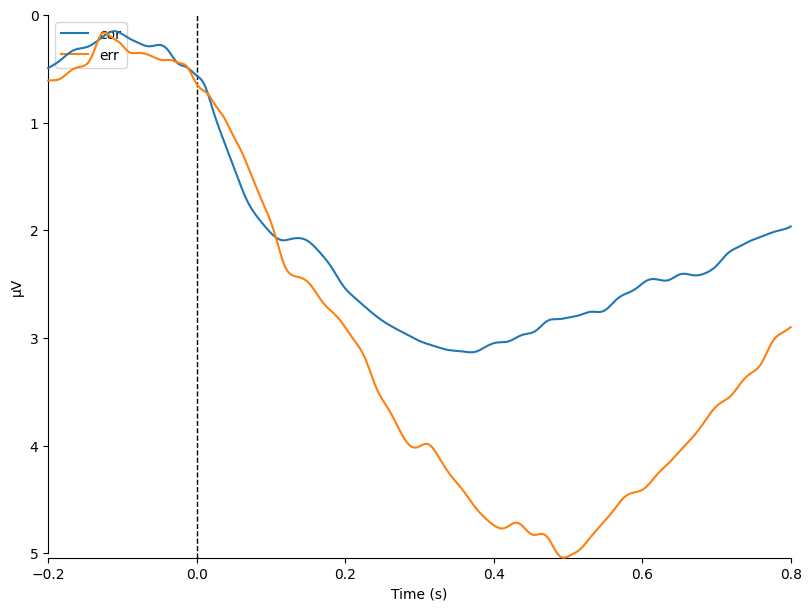

In [31]:
picks = 'data' # Lista elektrod lub data
fig = mne.viz.plot_compare_evokeds(
    evokeds = {'cor': epochs_train['cor'].average(), 'err': epochs_train['err'].average()},
    picks=picks,
    invert_y=True
)

In [ ]:
# Proba znalezienia dobrej elektrody wrozebnej 🧙

import numpy as np
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline

res = {}
for ch in epochs_train.ch_names:
    cor_data = epochs_train.get_data(picks=[ch], item='cor')
    err_data = epochs_train.get_data(picks=[ch], item='err')

    idx = np.random.randint(cor_data.shape[0], size=err_data.shape[0])
    cor_data = cor_data[idx,:,:]  # Wyrownanie liczebnosci klas

    X_train = np.concatenate((np.mean(cor_data, axis=(1,2)), np.mean(err_data, axis=(1,2)))).reshape(-1, 1)
    y_train = np.concatenate((np.repeat(2, cor_data.shape[0]), np.repeat(3, err_data.shape[0])))

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    ).fit(X_train, y_train)

    y_pred = clf.predict(X_train)
    res[ch] = accuracy_score(y_true=y_train, y_pred=y_pred)
    print(ch, res[ch])
    

print('Max', max(res, key=res.get))

E1 0.46898334290637567
E2 0.47759908098793796
E3 0.4997128087306146
E4 0.48219414129810456
E5 0.46639862148190697
E6 0.4373923032739805
E7 0.5445146467547387
E8 0.49425617461229177
E9 0.4956921309592188
E10 0.4758759333716255
E11 0.46869615163699024
E12 0.4646754738655945
E13 0.47472716829408385
E14 0.4865020103388857
E15 0.4865020103388857
E16 0.483917288914417
E17 0.47731188971855254
E18 0.4816197587593337
E19 0.48736358414704195
E20 0.5393452039058013
E21 0.4842044801838024
E22 0.49339460080413555
E23 0.49310740953475013
E24 0.4701321079839173
E25 0.5005743825387708
E26 0.5175186674325101
E27 0.5330269959793222
E28 0.4813325674899483
E29 0.4865020103388857
E30 0.4764503159103963
E31 0.5080413555427915
E32 0.4732912119471568
E33 0.5479609419873636
E34 0.5499712808730615
E35 0.4770246984491672
E36 0.4919586444572085
E37 0.5192418150488225
E38 0.5649052268811028
E39 0.539919586444572
E40 0.46352670878805285
E41 0.4784606547960942
E42 0.4971280873061459
E43 0.5479609419873636
E44 0.5496

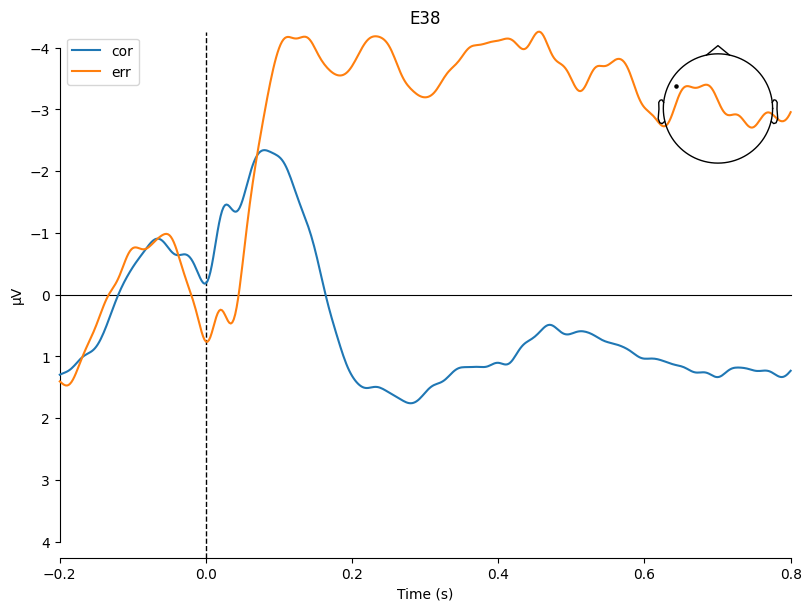

In [ ]:
picks = ['E38'] 
fig = mne.viz.plot_compare_evokeds(
    evokeds = {'cor': epochs_train['cor'].average(), 'err': epochs_train['err'].average()},
    picks=picks,
    invert_y=True
)


In [106]:
epochs_test = mne.concatenate_epochs(P_test[:10])

/var/folders/xn/rmm5z03542xdnxzq5ct_mndr0000gn/T/ipykernel_59413/3430198953.py:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs_test = mne.concatenate_epochs(P_test[:10])


Not setting metadata
3975 matching events found
Applying baseline correction (mode: mean)


In [ ]:
from mne.decoding import LinearModel, Vectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC


def prepare_X_y(epochs: mne.Epochs, tmin=0.0, tmax=0.8, picks='all'):
    cor_data = epochs.get_data(picks=picks, item='cor', tmin=tmin, tmax=tmax)
    err_data = epochs.get_data(picks=picks, item='err', tmin=tmin, tmax=tmax)

    idx = np.random.randint(cor_data.shape[0], size=err_data.shape[0])
    cor_data = cor_data[idx,:,:]  # Wyrownanie liczebnosci klas

    X = np.concatenate((cor_data, err_data))
    # X = np.mean(X, axis=2)
    X = X.reshape(X.shape[0], -1)
    y = np.concatenate((np.repeat(0, cor_data.shape[0]), np.repeat(1, err_data.shape[0])))
    return X, y

# for n_picks in range(1, 10, 1):
# ref https://modma.lzu.edu.cn/static/references/128%20channel%20HydroCel%20Geodesic%20Sensor%20Net-DOT%20probe%20EEG.pdf
picks = [
    'E11', # Fz
    'E55', # Cz 
    'E62', # Pz  
    'E75' # Oz
]

X, y = prepare_X_y(epochs_train, picks=picks)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9) # Powinno być test_size=0.2, to jest debugowo dla szybkosci

clf = make_pipeline(
    Vectorizer(),
    StandardScaler(),
    # LogisticRegression(solver='newton-cholesky') # inny solver rzuca blad
    # SVC(C=1)
    LinearModel(
        LinearDiscriminantAnalysis(solver='svd')
    )
).fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
print(classification_report(y_train, y_pred_train))

y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))